In [2]:
using Revise

In [4]:
push!(LOAD_PATH, "/home/amir/work/mps/src/")

using KrylovKit
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using FFTW
using LsqFit

using QuantumModels
using MatrixProductStateTools
using ExactDiagonalizationTools
using SymTensors
using GaussianFermions
using GutzwillerMPS

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1273
┌ Info: Precompiling QuantumModels [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling MatrixProductStateTools [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling ExactDiagonalizationTools [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling GaussianFermions [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling GutzwillerMPS [top-level]
└ @ Base loading.jl:1273


In [5]:
include("/home/amir/work/mps/test/runtests.jl")

┌ Warning: Operator has identity with amplitude 0.25
└ @ QuantumModels /home/amir/work/mps/src/spin_definitions.jl:106


Test Summary: | Pass  Total
Model         |    2      2
Test Summary: | Pass  Total
MPS           |    8      8
Test Summary: | Pass  Total
apply         |    2      2
Test Summary: | Pass  Total
MPO           |   11     11
Test Summary: | Pass  Total
MPOgen        |   22     22
Test Summary: | Pass  Total
releg         |    3      3
Test Summary: | Pass  Total
contract      |    3      3
Test Summary: | Pass  Total
LA fns        |    1      1


Test.DefaultTestSet("LA fns", Any[Test.DefaultTestSet("dot", Any[], 1, false)], 0, false)

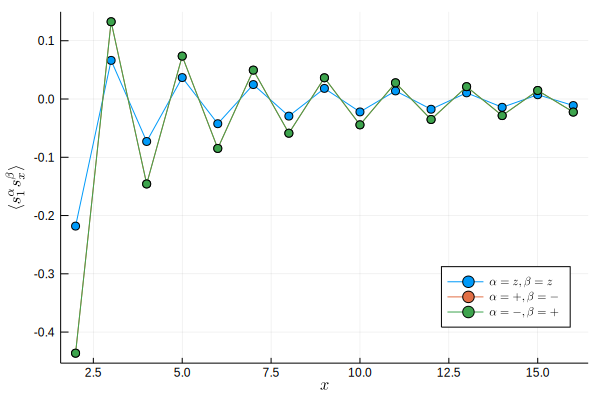

In [6]:
# exact Heisenberg AF mps
lx = 16
H, block_states = xxz_hamiltonian(lx, mode=:U1)
es, vs = eigsolve(H, 1, :SR, ishermitian=true)
mpsheis = SymMatrixProductState(lx, 2, vs[1]) 
sz, sp, sm = spinoperators(1/2, symmetry=:U1)
heis_pm = measure_2point(mpsheis, sp, sm)
heis_mp = measure_2point(mpsheis, sm, sp)
heis_zz = measure_2point(mpsheis, sz, sz)
indexes = [half_measurement_index(lx,1,l+1) for l=1:lx-1]

p = plot(xaxis=(L"$x$"), yaxis=(L"$\langle s^\alpha_1 s^\beta_x\rangle$"), legend=:bottomright)
plot!(p, [2:lx], heis_zz[indexes], marker=(:circle), label=L"\alpha=z, \beta=z")
plot!(p, [2:lx], heis_pm[indexes], marker=(:circle), label=L"\alpha=+, \beta=-")
plot!(p, [2:lx], heis_mp[indexes], marker=(:circle), label=L"\alpha=-, \beta=+")

In [8]:
# Fermionic hopping mps using Fishman gates
L = 1 * lx
m = 100
hamil = generatebdg(triangularhopping((1,lx), 1.0, 15., 15., 15., boundary=(:OBC, :OBC)))
cm = correlationmatrix(hamil, div(L,2))
fgs = generate_fishmangates(cm)
mps = fishman2mps(fgs, m, symmetry=:U1)

fhop_pm = measure_2point(mps, sp, sm)
#fhop_mp = measure_2point(mps, sm, sp)
fhop_zz = measure_2point(mps, sz, sz)
indexes = [half_measurement_index(lx,1,l+1) for l=1:lx-1]

p = plot(xaxis=(L"$x$"), yaxis=(L"$\langle s^\alpha_1 s^\beta_x\rangle$"), legend=:bottomright)
plot!(p, [2:lx], fhop_zz[indexes], marker=(:circle), label=L"\alpha=z, \beta=z")
plot!(p, [2:lx], fhop_pm[indexes], marker=(:circle), label=L"\alpha=+, \beta=-")
#plot!(p, [2:lx], fhop_mp[indexes], marker=(:circle), label=L"\alpha=-, \beta=+")

ErrorException: type QLattice has no field bc

In [ ]:
# zip and gutzwiller method
mpsgutz = zipandgutzwiller!(mps, mps, maxdim=10);
@show norm2(mpsgutz)
normalize!(mpsgutz)

In [ ]:
entgutz = entanglemententropy(mpsgutz);
entheis = entanglemententropy(mpsheis);

@show mps_dims_are_consistent(mpsgutz)
zzdata = real.(measure_2point(mpsgutz, sz, sz))
pmdata = real.(measure_2point(mpsgutz, sp, sm)) 
mpdata = real.(measure_2point(mpsgutz, sm, sp)) 

pR = plot(xaxis=(L"$x$"), yaxis=(L"$\langle \mathbf{S}_1 \cdot \mathbf{S}_x\rangle$"), legend=false)
pF = plot(
    xaxis=(L"q", (0, pi), ([0,pi/2,pi], [L"0", L"\pi/2", L"\pi"])),
    yaxis=(L"\langle \mathbf{S}_q \cdot \mathbf{S}_{-q}\rangle"),
    legend=false
)

indexes = [half_measurement_index(lx,1,l+1) for l=1:lx-1]
data = zzdata[indexes] + pmdata[indexes]
data = vcat([3/4.], data)

#plot!(pR, [1:lx], data, marker=(:circle))
plot!(pR, [2:lx], zzdata[indexes], marker=(:circle))
plot!(pR, [2:lx], pmdata[indexes], marker=(:circle))
plot!(pR, [2:lx], mpdata[indexes], marker=(:circle))

fdata = rfft(data)
qs = range(0, pi, length=div(lx,2)+1)
#plot!(pF, qs, real.(fdata))
    
plot(pF, pR, size=(800,400), layout=(1,2))

In [ ]:
entgutz = entanglemententropy(mpsgutz);
entheis = entanglemententropy(mpsheis);

In [ ]:
@. fitfn(x, p) = p[1]/6 * log(lx/pi * sin(pi*x/lx)) + p[2]
fitgutz = curve_fit(fitfn, collect(1:lx-1), entgutz, [1., 0.5])
csgutz = coef(fitgutz)
println("Gutzwiller fit", csgutz)

fitheis = curve_fit(fitfn, collect(1:lx-1), entheis, [1., 0.5])
csheis = coef(fitheis)
println("Heisenberg fit", csheis)
xsfill = range(1, lx-1, length=100)

p = plot(
    xaxis=(L"\ell"),
    yaxis=(L"S_1(\ell)"),
    legend=:bottom
)
plot!(p, entgutz, label="Gutz")
plot!(p, xsfill, fitfn(xsfill, csgutz), label=latexstring("c = $(csgutz[1])"))

plot!(p, entheis, label="Heis")
plot!(p, xsfill, fitfn(xsfill, csheis), label=latexstring("c = $(csheis[1])"))